<a href="https://colab.research.google.com/github/kasurashan/hough_transform/blob/main/ComputerVision_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import copy
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/hough2.jpg'
img = cv2.imread(path, 0)   #grayscale image

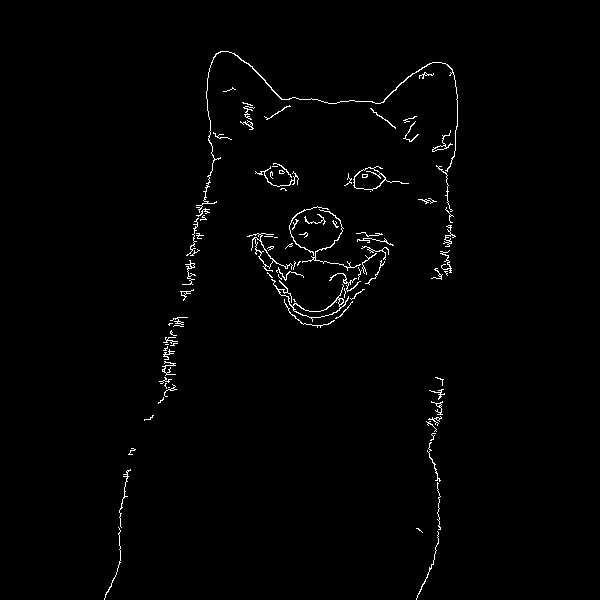

In [ ]:
# edge image
edge = cv2.Canny(img, 100, 255)
cv2.imwrite('edgeimage.jpg', edge)
cv2_imshow(edge)

In [ ]:
def hough_space(edge):
  theta = np.linspace(-90, 90, 1800)
  theta = np.deg2rad(theta)
  H, W = edge.shape
  Diag = int(np.sqrt(H**2 + W**2))
  rho_grid = np.linspace(-Diag, Diag, Diag*2)

  # 첫번째 col은 sin(theta)값들
  # 두번째 col은 cos(theta)값들
  SC = np.stack([np.sin(theta), np.cos(theta)]).T
  
  # edge에서 0이 아닌 곳의 idx (x좌표, y좌표)
  x, y = np.where(edge!=0)
  XY = np.stack([x,y])

  # sin(theta)*x + cos(theta)+y를 행렬곱으로 계산
  SCXY = SC@XY
  
  # 투표 할 공간 생성
  acc = np.zeros([rho_grid.shape[0], theta.shape[0]])

  # 투표 시작
  for theta_idx, scxy in tqdm(enumerate(SCXY)):
    diff = np.abs(scxy.reshape(1,-1).repeat(rho_grid.shape, axis=0) - rho_grid.reshape(-1,1))
    rho_idx = np.argmin(diff, axis=0)
    for i in rho_idx:
      acc[i, theta_idx] += 1

  return acc, theta, H, W, Diag, rho_grid

In [ ]:
acc, theta, H, W, Diag, rho_grid = hough_space(edge)

1800it [02:02, 14.67it/s]


In [ ]:
# acc에서 가장 큰 값의 index를 찾아서 저장하고
# 그 값을 acc에서 0으로 만든 후
# 다시 acc에서 가장 큰 값을 찾음
# 이 때, 새로 찾은 index가 기존의 index와 차이가 너무적으면 
# 저장하지 않음 (중복을 막기 위해서)

def line_detection(acc, rho, theta, n_detect, threshold):
  hough = copy.deepcopy(acc)

  # 가장 투표 많이 받은 index 찾기
  rho_idx = np.where(hough == hough.max())[0][0]
  theta_idx = np.where(hough == hough.max())[1][0]

  # index list에 저장
  idx_list = [[rho_idx, theta_idx]]

  # 저장한 이후 그 값은 0으로 만들어줌
  hough[rho_idx, theta_idx] = 0

  # 위 절차를 반복하기 위해 while문 사용
  while(len(idx_list) < n_detect):

    # 현 상태에서 가장 투표 많이 받은 index 찾기
    rho_idx = np.where(hough == hough.max())[0][0]
    theta_idx = np.where(hough == hough.max())[1][0]

    np_idx = np.array(idx_list)

    # 새롭게 찾은 index와 이전 index들 사이의 차이가 너무 작으면
    # 새롭게 찾은 index를 index list에 저장하지 않음
    # (중복된 직선이 너무 많이 나오지 않도록)
    # 그러기 위해 threshold 설정 
    # (theta방향 차이와 rho방향 차이를 더해준것과 비교)
    # rho_grid와 theta의 간격이 서로 다르기 때문에 
    # 이를 보정해주기 위해 한 쪽에 상수 곱해줌
    thr = abs(rho[np_idx[:,0]]-rho[rho_idx])  + abs(theta[np_idx[:,1]]-theta[theta_idx]) * (acc.shape[1]/acc.shape[0])
    if np.min(thr) > threshold :
      idx_list.append([rho_idx, theta_idx])
      hough[rho_idx, theta_idx] = 0
    else:
      hough[rho_idx, theta_idx] = 0

  # 최종적으로 얻어진 index list (n_list개 만큼 찾음)
  idx_arr = np.array(idx_list)

  rho_select = rho[idx_arr[:,0]]
  theta_select = theta[idx_arr[:,1]]

  return idx_arr, rho_select, theta_select


idx, rho_select, theta_select = line_detection(acc, rho_grid, theta, 10, 10)

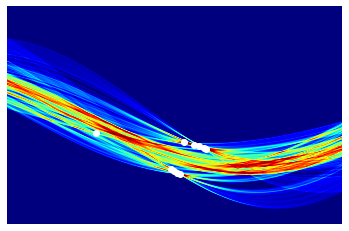

In [ ]:
# acc에 저장된 값에 대해 시각화를 더 잘 보이게 하기 위해
# 전체적으로 값을 10배 해준다
# RGB값의 한계는 255이므로 255를 넘으면 전부 255로 맞춰준다
ACC = acc * 10
ACC[ACC>255] = 255
plt.imshow(ACC, cmap='jet', aspect='auto')
plt.plot(idx[:,1], idx[:,0], 'wo')
plt.axis('off')

# 구글 코랩 /content 폴더에 저장됨
plt.savefig(f'./houghspace.jpg', dpi=300)
plt.show()


In [ ]:
!ls

DetectedLines.jpg  drive  edgeimage.jpg  houghspace.jpg  sample_data


In [ ]:
# 위에서 찾은 index들에 대해
# 실제 이미지에 직선을 그려준다

def draw_line(edge, theta_select, rho_select, H, W):
  
  # 분모가 0이 되지 않도록
  eps = 0.00001
  
  # 기울기, 절편을 구해준다
  slope = -np.cos(theta_select) / (np.sin(theta_select) + eps)
  bias = rho_select / (np.sin(theta_select) + eps)

  # 실제 edge 이미지
  plt.figure()
  plt.imshow(edge, cmap='gray') 

  # 위에서 찾은 index pair의 개수
  num = len(slope)

  # 각각의 index를 직선으로 그려준다
  for i in range(num):
    for w in range(W):
      y = slope[i] * w + bias[i]
      if y >= 0 and y < H:
        plt.plot(w, y, marker='.', color='red')
    for h in range(H):
      x = (h-bias[i]) / slope[i]
      if x >=0 and x < W:
        plt.plot(x, h, marker='.', color='red')
  
  plt.savefig(f'./DetectedLines.jpg', dpi=300)



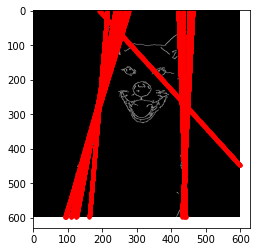

In [ ]:
draw_line(edge, theta_select, rho_select, H, W)